## Requirements

 ```bash
 conda create --name keras_dl
 conda activate keras_dl
 conda install -c anaconda ipykernel
 python -m ipykernel install --user --name=firstEnv
 https://phoenixnap.com/kb/how-to-install-keras-on-linux
 ```

In [1]:
from google_images_download import google_images_download
import os

In [2]:
response = google_images_download.googleimagesdownload()

HOME = './Data/'
import shutil

In [3]:


def download_images(home_folder, dict_folder, classes):
    # Make folder structure
    n_images = sum([dict_folder[label] for label in dict_folder])
    print(n_images)
    for label in classes:
        arguments = {
                    "keywords":label,"limit":n_images,"print_urls":False,
                    "size":"large",
                    "output_directory":home_folder
                    }   #creating list of arguments
        paths = response.download(arguments)   #passing the arguments to the function
        
        
        for folder in dict_folder:
            img_per_set = dict_folder[folder]
            output_folder = home_folder + folder + '/' + label
            
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
                
            all_files = os.listdir(home_folder + label)
            for index, file in enumerate(all_files):
                if index < img_per_set:
                    
                    shutil.move(
                        home_folder + label + '/' + file,
                        output_folder + '/' + file)
                all_files = os.listdir(home_folder + label)




In [4]:
# make dict
dict_folders = {'Train':30, 'Val':10, 'Inf':5}
classes = ['fire', 'ice']
download_images(HOME, dict_folders, classes)


45

Item no.: 1 --> Item name = fire
Evaluating...
Starting Download...


Unfortunately all 45 could not be downloaded because some images were not downloadable. 0 is all we got for this search filter!

Errors: 0


Item no.: 1 --> Item name = ice
Evaluating...
Starting Download...


Unfortunately all 45 could not be downloaded because some images were not downloadable. 0 is all we got for this search filter!

Errors: 0



## Import everything for the image classificaiton

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [59]:


img_size = 256
# set the epochs
epochs = 50

def get_data(data_dir, classes):
    data = [] 
    for label in classes: 
        path = os.path.join(data_dir, label)
        class_num = classes.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)


In [60]:
train = get_data(HOME + 'Train/', classes)
val = get_data(HOME + 'Val/', classes)

<AxesSubplot:ylabel='count'>

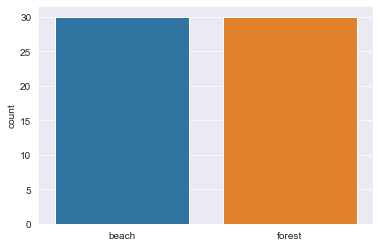

In [61]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("beach")
    else:
        l.append("forest")
sns.set_style('darkgrid')
sns.countplot(x=l)


Text(0.5, 1.0, 'car')

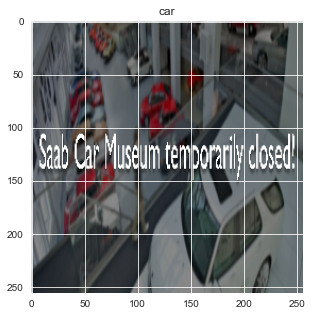

In [62]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(classes[train[0][1]])

Text(0.5, 1.0, 'tree')

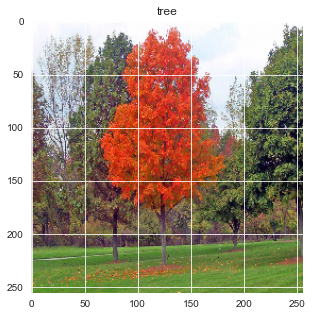

In [63]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(classes[train[-1][1]])

In [64]:
# Prepare the data

x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [65]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [66]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size,img_size,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 64)       

In [67]:
opt = Adam(lr=0.0001)
model.compile(
    optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics = ['accuracy']
            )

In [68]:
history = model.fit(x_train,y_train,epochs = epochs , validation_data = (x_val, y_val))

Epoch 1/50
2/2 [==============================] - 5s 3s/step - loss: 0.7187 - accuracy: 0.5104 - val_loss: 0.7157 - val_accuracy: 0.5000
Epoch 2/50
2/2 [==============================] - 5s 2s/step - loss: 0.6994 - accuracy: 0.5229 - val_loss: 0.6402 - val_accuracy: 0.7500
Epoch 3/50
2/2 [==============================] - 5s 3s/step - loss: 0.5977 - accuracy: 0.7500 - val_loss: 0.6431 - val_accuracy: 0.6000
Epoch 4/50
2/2 [==============================] - 7s 4s/step - loss: 0.5881 - accuracy: 0.5868 - val_loss: 0.5912 - val_accuracy: 0.8500
Epoch 5/50
2/2 [==============================] - 13s 7s/step - loss: 0.5271 - accuracy: 0.9236 - val_loss: 0.5889 - val_accuracy: 0.7000
Epoch 6/50
2/2 [==============================] - 11s 5s/step - loss: 0.4955 - accuracy: 0.8799 - val_loss: 0.5372 - val_accuracy: 0.8500
Epoch 7/50
2/2 [==============================] - 11s 5s/step - loss: 0.4219 - accuracy: 0.9458 - val_loss: 0.5338 - val_accuracy: 0.8500
Epoch 8/50
2/2 [======================

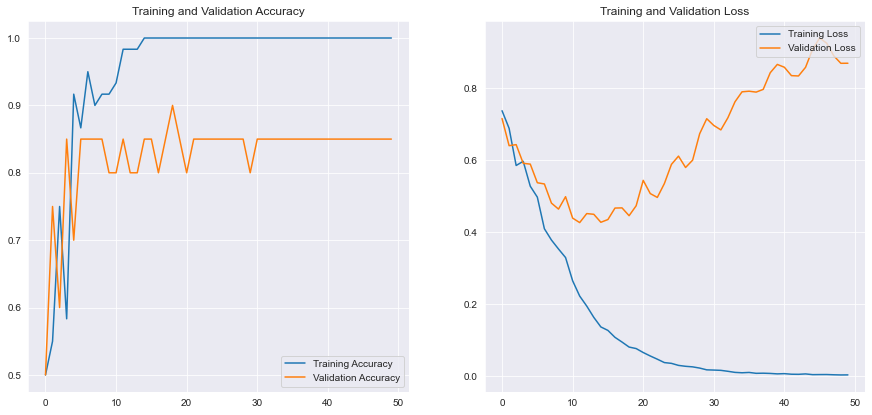

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs as variable
epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [70]:
predictions = np.argmax(model.predict(x_val), axis=-1)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['beach (Class 0)','forest (Class 1)']))

                  precision    recall  f1-score   support

 beach (Class 0)       0.89      0.80      0.84        10
forest (Class 1)       0.82      0.90      0.86        10

        accuracy                           0.85        20
       macro avg       0.85      0.85      0.85        20
    weighted avg       0.85      0.85      0.85        20



# Inference

In [71]:
import random
from IPython.display import display, Image

path = HOME + 'Inf/'

inference_files = [os.path.join(root, name)
                  for root, dirs, files in os.walk(path)
                  for name in files]


./Data/Inf/tree/6.full-green-tree.png
This image is 100.0 percent car and 0.0 percent tree.


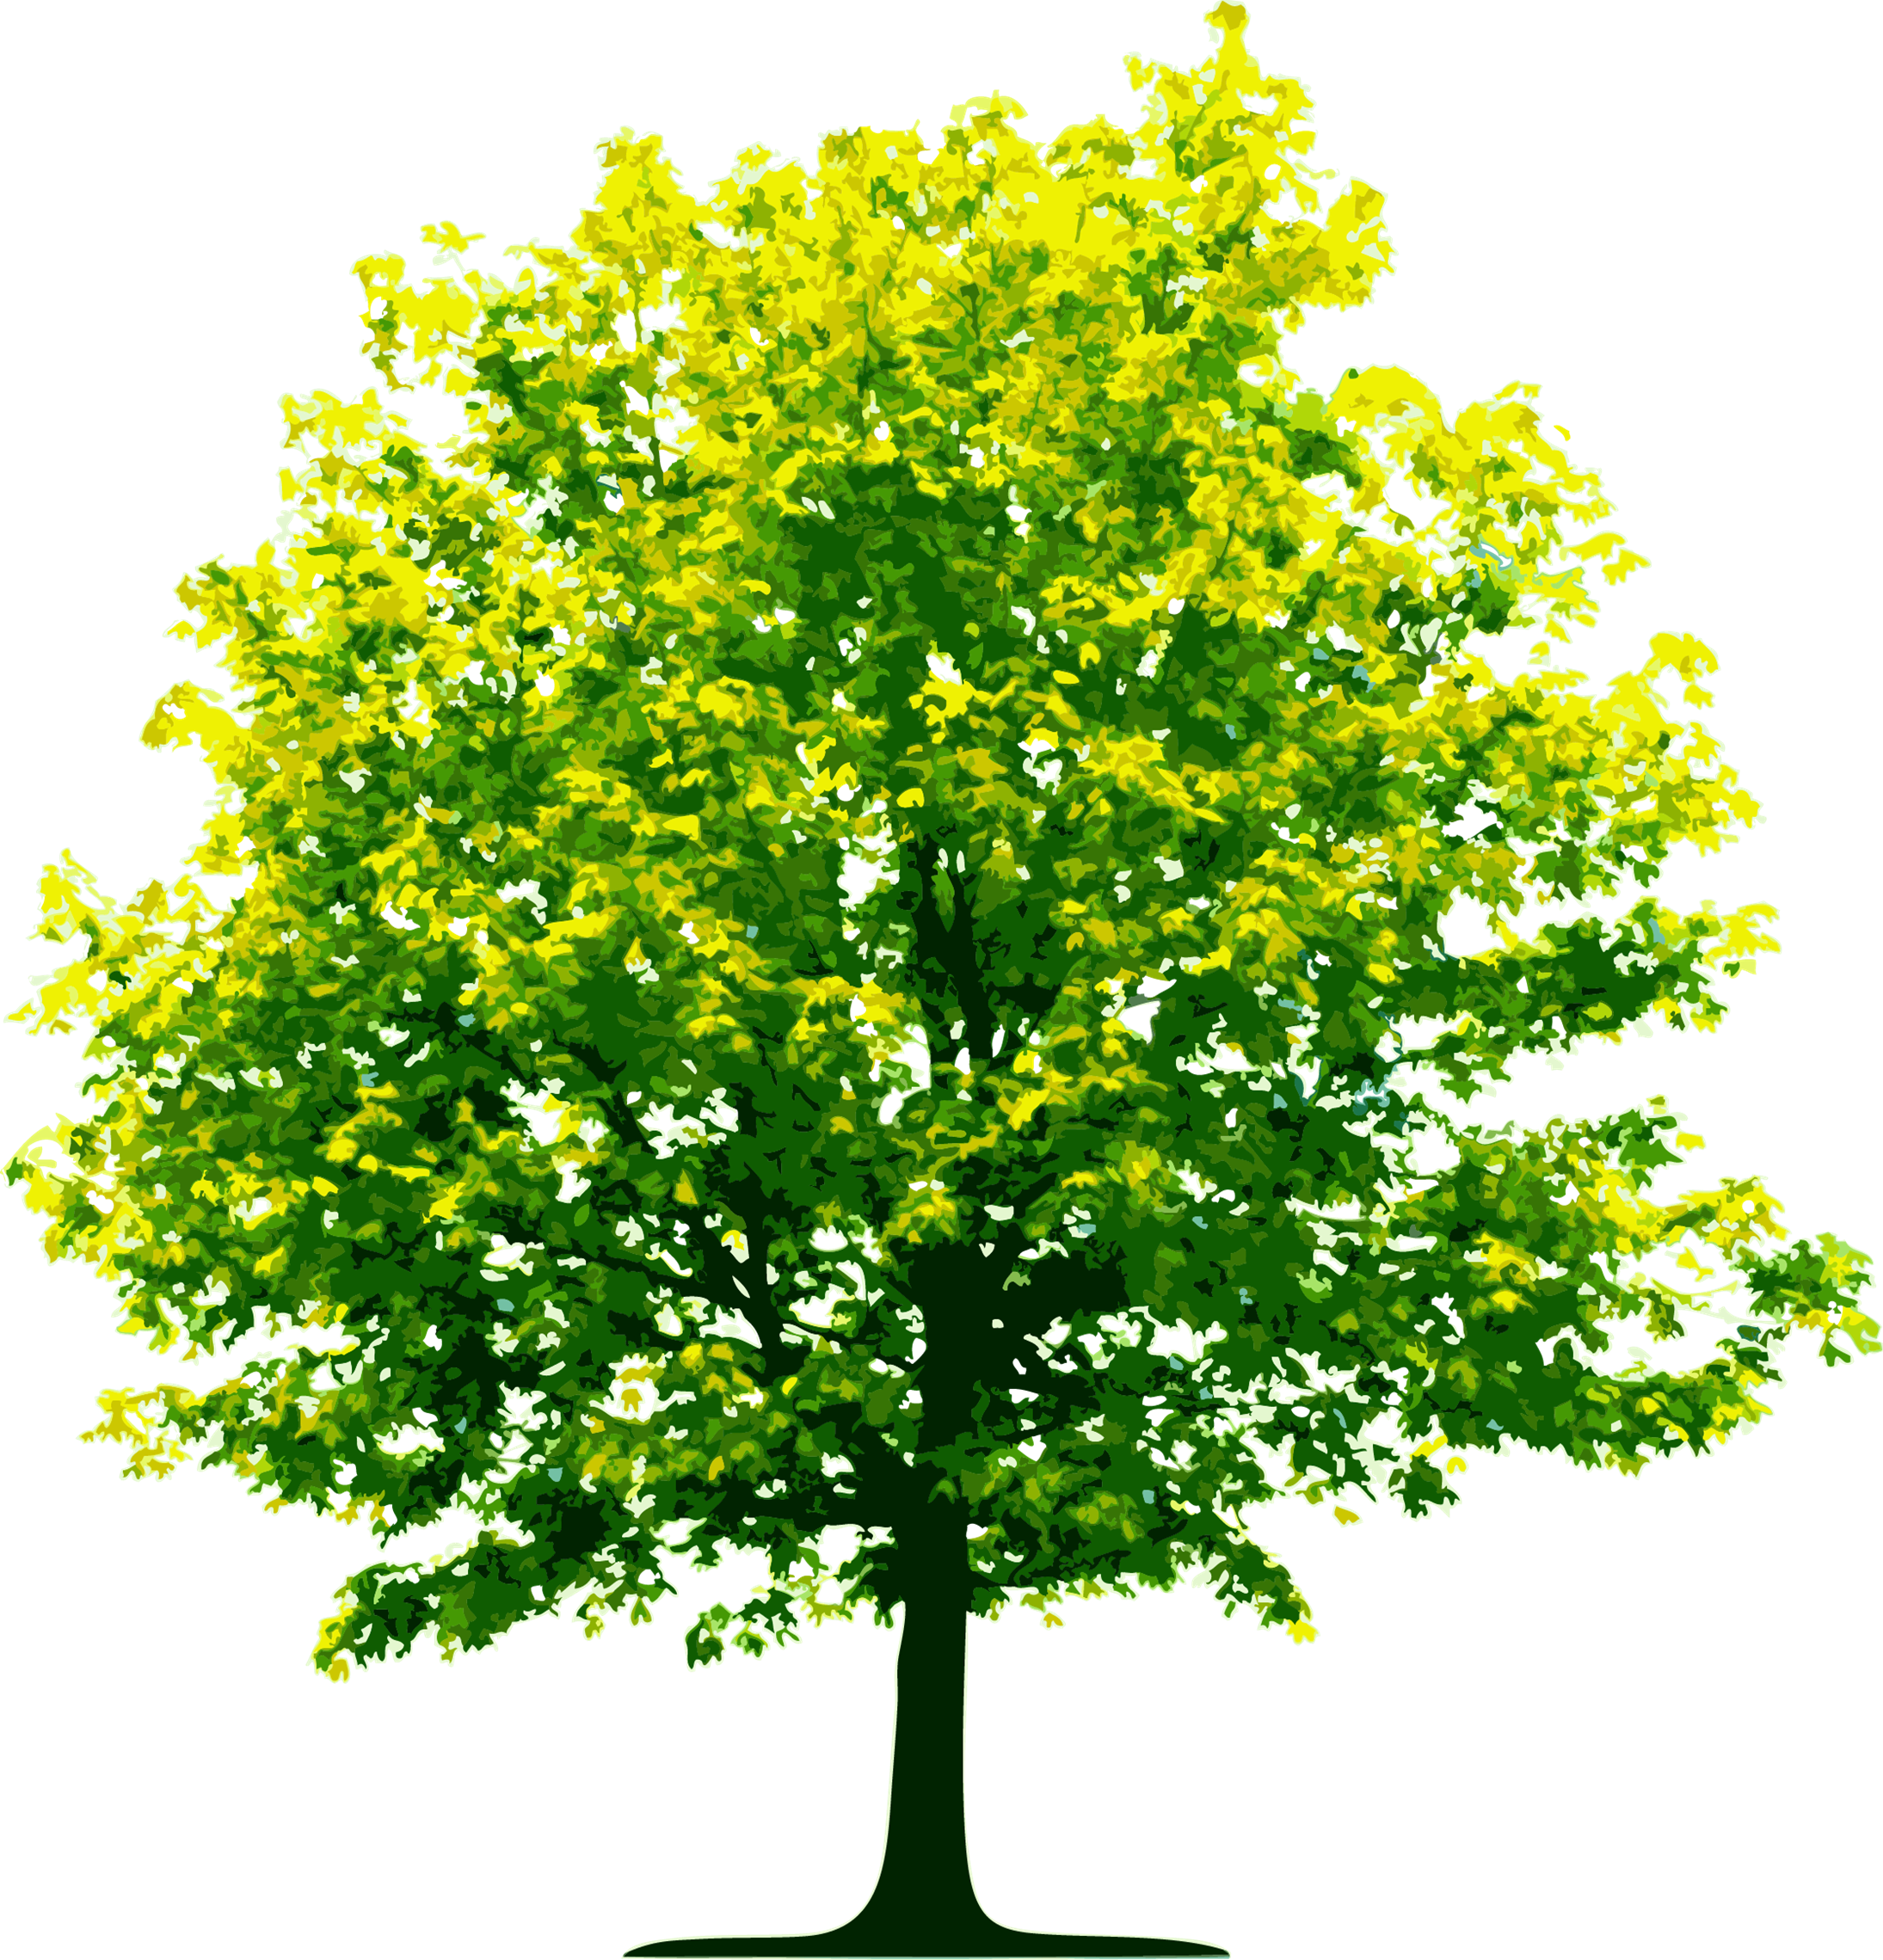

In [96]:
rdm_img = random.choice(inference_files)

image_size = (256,256)


print(rdm_img)

img = keras.preprocessing.image.load_img(
    rdm_img, target_size=image_size
    )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0]
print(
    'This image is %.1f percent %s and %.1f percent %s.'
    %(score[0] * 100, classes[0], score[1] * 100, classes[1]))
Image(filename=rdm_img)

# Transfer learning

In [126]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")

In [127]:
base_model.trainable = False

In [128]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(2, activation="softmax")                                     
                                ])
epochs = 100

In [129]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
               loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train,y_train,epochs = 100 , validation_data = (x_val, y_val))

Epoch 1/100
2/2 [==============================] - 8s 4s/step - loss: 0.7925 - accuracy: 0.5104 - val_loss: 0.7666 - val_accuracy: 0.4500
Epoch 2/100
2/2 [==============================] - 5s 3s/step - loss: 0.7656 - accuracy: 0.5319 - val_loss: 0.7415 - val_accuracy: 0.4500
Epoch 3/100
2/2 [==============================] - 4s 2s/step - loss: 0.7465 - accuracy: 0.5208 - val_loss: 0.7183 - val_accuracy: 0.4500
Epoch 4/100
2/2 [==============================] - 8s 4s/step - loss: 0.7944 - accuracy: 0.6090 - val_loss: 0.6961 - val_accuracy: 0.5500
Epoch 5/100
2/2 [==============================] - 4s 2s/step - loss: 0.6968 - accuracy: 0.6083 - val_loss: 0.6750 - val_accuracy: 0.6500
Epoch 6/100
2/2 [==============================] - 5s 3s/step - loss: 0.7020 - accuracy: 0.5444 - val_loss: 0.6550 - val_accuracy: 0.6500
Epoch 7/100
2/2 [==============================] - 5s 3s/step - loss: 0.6814 - accuracy: 0.5979 - val_loss: 0.6356 - val_accuracy: 0.6500
Epoch 8/100
2/2 [=================

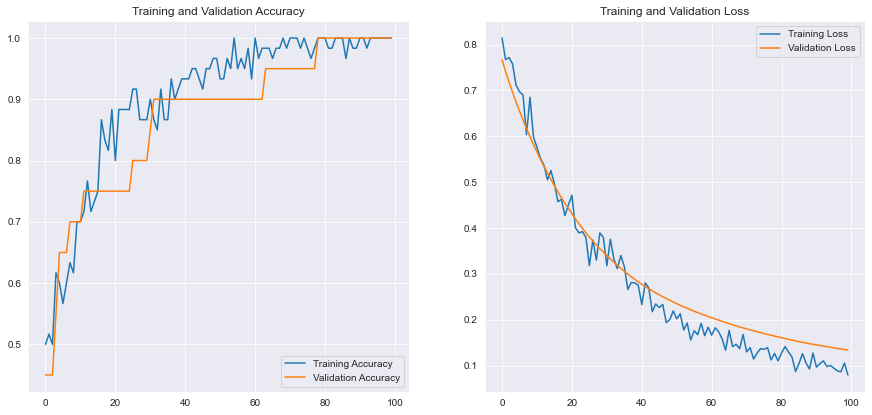

In [131]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Inference on transfer learning

./Data/Inf/car/18.porsche_911_carrera_s_manual_tracking.jpg
This image is 8.4 percent car and 91.6 percent tree.


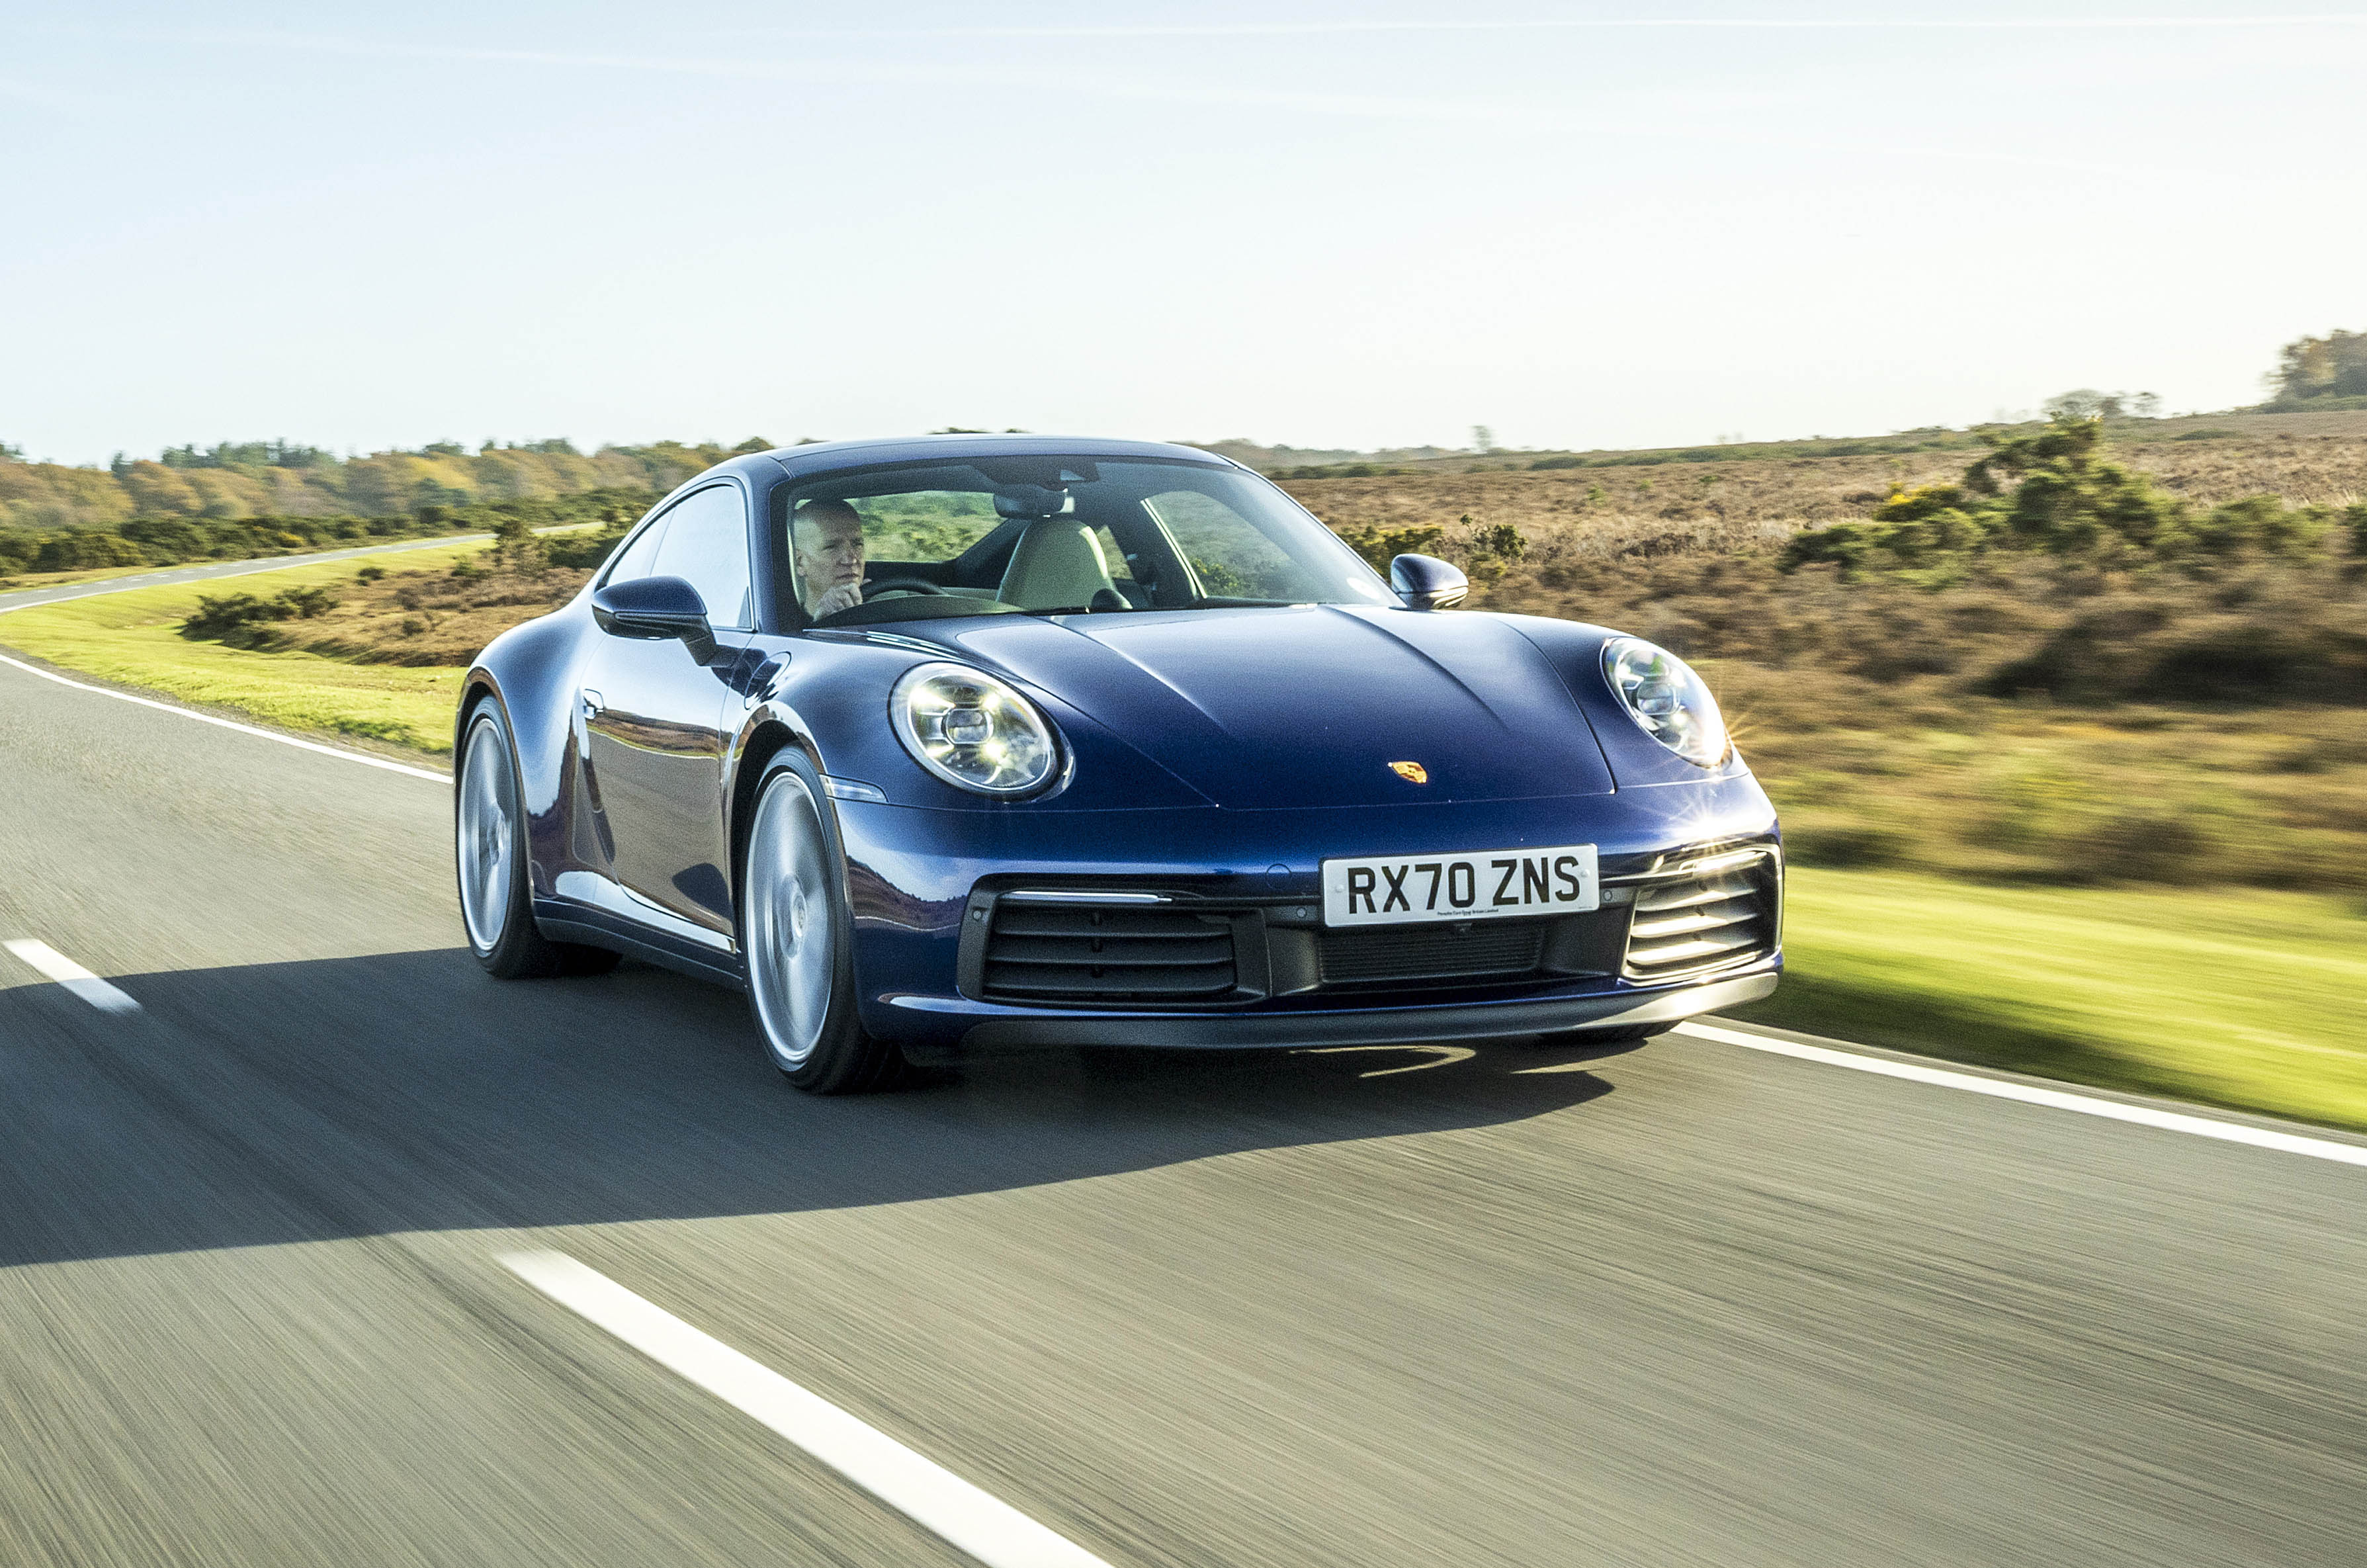

In [137]:
rdm_img = random.choice(inference_files)

image_size = (256,256)


print(rdm_img)

img = keras.preprocessing.image.load_img(
    rdm_img, target_size=image_size
    )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0]
print(
    'This image is %.1f percent %s and %.1f percent %s.'
    %(score[0] * 100, classes[0], score[1] * 100, classes[1]))
Image(filename=rdm_img)